In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pylab as plt
import copy

import sys
sys.path.append("..")
sys.path.append("../../fdfdpy")

from fdfdpy import Simulation
from structures import three_port, two_port
from optimization import Optimization
from utils import Binarizer

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
lambda0 = 2e-6              # free space wavelength (m)
c0 = 3e8                    # speed of light in vacuum (m/s)
omega = 2*np.pi*c0/lambda0  # angular frequency (2pi/s)
dl = 0.4e-1                 # grid size (L0)
NPML = [25, 25]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')
source_amp = 20             # amplitude of modal source (A/L0^2?)

In [3]:
# material constants
n_index = 2.44              # refractive index
eps_m = n_index**2          # relative permittivity
chi3 = 4.1*1e-19            # Al2S3 from Boyd (m^2/V^2)
# max_ind_shift = 5.8e-3      # maximum allowed nonlinear refractive index shift (computed from damage threshold)

In [4]:
# geometric parameters
L = 10         # length of box (L0)
H = 1        # height of box (L0)
w = .3        # width of waveguides (L0)
d = H/2.44    # distance between waveguides (L0)
l = 4         # length of waveguide from PML to box (L0)
spc = 1.5       # space between box and PML (L0)

Computed a domain with 500 grids in x and 150 grids in y
The simulation has 50 grids per free space wavelength


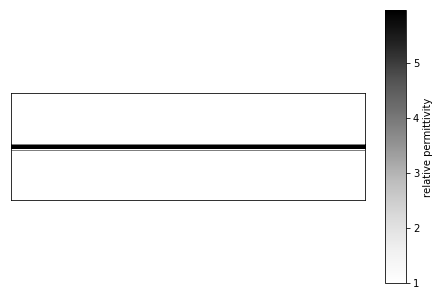

In [18]:
# define permittivity of three port system
eps_r, design_region = two_port(L, H, w, l, spc, dl, NPML, eps_m)
(Nx, Ny) = eps_r.shape
nx, ny = int(Nx/2), int(Ny/2)            # halfway grid points

simulation = Simulation(omega,eps_r,dl,NPML,pol)
# compute the grid size the total grid size
print("Computed a domain with {} grids in x and {} grids in y".format(Nx,Ny))
print("The simulation has {} grids per free space wavelength".format(int(lambda0/dl/simulation.L0)))
simulation.plt_eps()
plt.show()

In [19]:
# set the modal source and probes
simulation = Simulation(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny], int(Ny/3), scale=source_amp)
simulation.setup_modes()

# top modal profile
out = Simulation(omega, eps_r, dl, NPML, 'Ez')
out.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny], int(Ny/3))
out.setup_modes()
J_out = np.abs(out.src)

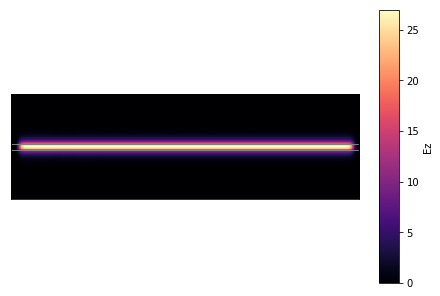

In [20]:
# set source and solve for electromagnetic fields
(_, _, Ez) = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True);

In [21]:
# compute straight line simulation
eps_r_wg, _ = two_port(L, H, w, l, spc, dl, NPML, eps_start=eps_m)
(Nx_wg, Ny_wg) = eps_r_wg.shape
nx_wg, ny_wg = int(Nx_wg/2), int(Ny_wg/2)            # halfway grid points     
simulation_wg = Simulation(omega, eps_r_wg, dl, NPML, 'Ez')
simulation_wg.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny_wg], int(Ny/3), scale=source_amp)
simulation_wg.setup_modes()

# compute normalization
sim_out = Simulation(omega, eps_r_wg, dl, NPML, 'Ez')
sim_out.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny], int(Ny/3))
sim_out.setup_modes()
J_out = np.abs(sim_out.src)
(_, _, Ez_wg) = simulation_wg.solve_fields()
SCALE = np.sum(np.square(np.abs(Ez_wg))*J_out)
J_out = J_out/SCALE
print('computed a scale of {} in units of E^2 J_out'.format(SCALE))

computed a scale of 1734.4671747927882 in units of E^2 J_out


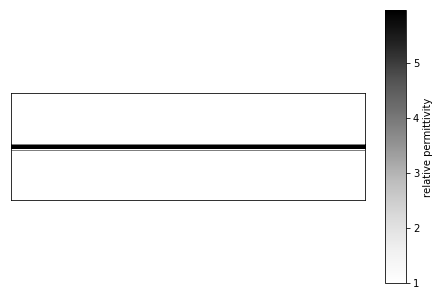

In [22]:
# changes design region. 'style' can be in {'full', 'empty', 'halfway', 'random'}
simulation.init_design_region(design_region, eps_m, style=' ')
simulation.plt_eps()
plt.show()

In [23]:
# add nonlinearity
nl_region = copy.deepcopy(design_region)

simulation.nonlinearity = []  # This is needed in case you re-run this cell, for example (or you can re-initialize simulation every time)
simulation.add_nl(chi3, nl_region, eps_scale=True, eps_max=eps_m)

In [26]:
# define objective function
import autograd.numpy as npa
def J(e, e_nl):
    linear_out =     1*npa.sum(npa.square(npa.abs(e))*J_out)
    nonlinear_out = -1*npa.sum(npa.square(npa.abs(e_nl))*J_out)
    return linear_out + nonlinear_out

In [27]:
# make optimization object and check derivatives
R = 3   # filter radius of curvature (pixels)  (takes a while to set up as R > 5-10)
beta = 10
eta= 0.5
# simulation.init_design_region(design_region, eps_m, style='')
# simulation.rho[design_region==1] = 1/(1+np.exp(-(simulation.rho[design_region==1]-0.5)))
optimization = Optimization(J=J, simulation=simulation, design_region=design_region, eps_m=eps_m, R=R, beta=beta, eta=eta)

In [28]:
# check the derivatives (note, full derivatives are checked, linear and nonlinear no longer separate)
(grad_avm, grad_num) = optimization.check_deriv(Npts=5, d_rho=5e-4)
print('adjoint gradient   = {}\nnumerical gradient = {}'.format(grad_avm, grad_num))

adjoint gradient   = [3.734299635420079e-10, 5.851184040687478e-08, -4.0213805378649475e-11, 2.0744322475406855e-07, -6.017185971837601e-08]
numerical gradient = [3.5127456499139953e-10, 5.850431250564725e-08, -5.1958437552457326e-11, 2.0741430795112592e-07, -6.018341380809034e-08]


In [29]:
new_eps = optimization.run(method='lbfgs', Nsteps=100, step_size=2e-3)

 ObjectiveFn:  0.918 Iteration:  99/100 ETA:   0:00:07                         

In [16]:
rho_saved = copy.deepcopy(simulation.rho)

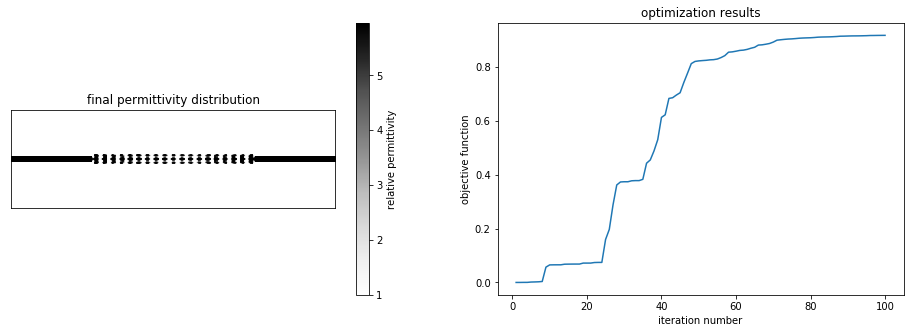

In [30]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
simulation.plt_eps(ax=ax1, outline=False)
ax1.set_title('final permittivity distribution')
optimization.plt_objs(ax=ax2)
ax2.set_yscale('linear')
plt.show()

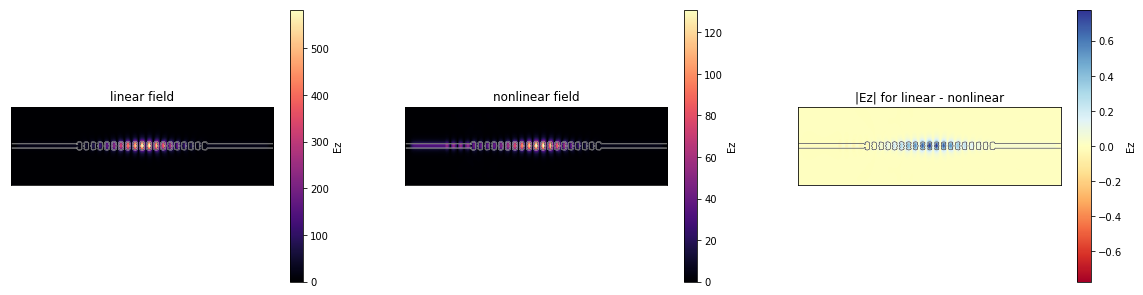

In [31]:
# compare the linear and nonlinear fields

# setup subplots
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))

# linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs(ax=ax1, vmax=None)
ax1.set_title('linear field')

# nonlinear fields
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
simulation.plt_abs(ax=ax2, vmax=None, nl=True)
ax2.set_title('nonlinear field')

# difference
simulation.plt_diff(ax=ax3)
ax3.set_title('|Ez| for linear - nonlinear')

plt.show()

maximum refractive index shift of 0.00430421264426073


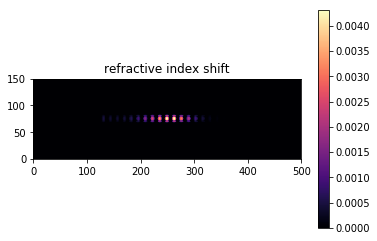

In [32]:
# compute the refractive index shift
index_shift = simulation.compute_index_shift()
print('maximum refractive index shift of {}'.format(np.max(index_shift)))
plt.imshow(index_shift.T, cmap='magma', origin='lower')
plt.colorbar()
plt.title('refractive index shift')
plt.show()

In [33]:
# compute powers

# input power
W_in = simulation.W_in

# linear powers
(Hx,Hy,Ez) = simulation.solve_fields()
W_out_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny], int(Ny/2))
W_in_lin = simulation.flux_probe('x', [NPML[0]+int(2*l/3/dl), ny], int(Ny/2))

T_lin = W_out_lin/W_in

# nonlinear powers
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
W_out_nl = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny], int(Ny/2), nl=True)
W_in_nl = simulation.flux_probe('x', [NPML[0]+int(2*l/3/dl), ny], int(Ny/2), nl=True)

T_nl = W_out_nl/W_in

print('linear transmission              = {:.4f}'.format(T_lin))
print('nonlinear transmission           = {:.4f}\n'.format(T_nl))
print('relative power difference        = {:.2f} %'.format(100*abs(W_out_lin-W_out_nl)/W_out_lin))
print('relative transmission difference = {:.2f} %'.format(100*abs(T_lin-T_nl)/T_lin))


linear transmission              = 0.9614
nonlinear transmission           = 0.0476

relative power difference        = 95.05 %
relative transmission difference = 95.05 %


100% (200 of 200) |######################| Elapsed Time: 0:05:23 ETA:  00:00:00

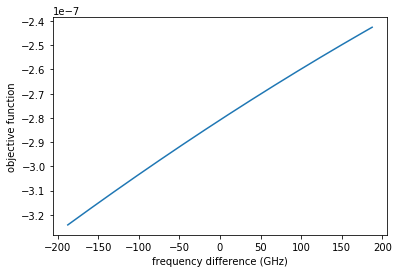

computed FWHM of 0.0 (GHz):
Q factor of INF


In [21]:
freqs, objs, FWHM = optimization.scan_frequency(Nf=200, df=1/400)
optimization.simulation.omega = omega
plt.plot([(f-150e12)/1e9 for f in freqs], objs)
plt.xlabel('frequency difference (GHz)')
plt.ylabel('objective function')
plt.show()
print('computed FWHM of {} (GHz):'.format(FWHM/1e9))
print('Q factor of {0:.2E}'.format(omega/2/np.pi/FWHM))

In [22]:
np.save('../data/figs/data/2port_th_eps', simulation.eps_r)
np.save('../data/figs/data/2port_th_objfn_list', optimization.objfn_list)
np.save('../data/figs/data/2port_th_freqs', freqs)
np.save('../data/figs/data/2port_th_objs', objs)
